In [24]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Distances
using Random
using DelimitedFiles
using Statistics
using Printf
using FileIO

include("./DIVAnd_sediment.jl")

emodnet2nc

In [25]:
datafile = "./data/GranulometrySlovenian.csv"
bathyfile = "./data/NorthAdriatic.nc"
isfile(datafile) ? @info("Data file already downloaded") : download("https://dox.ulg.ac.be/index.php/s/VzrZ4e8tY7SYims/download", datafile);
isfile(bathyfile) ? @info("Bathymetry file already downloaded") : download("https://dox.ulg.ac.be/index.php/s/w8IS0QAtApA62iv", bathyfile);

┌ Info: Data file already downloaded
└ @ Main In[25]:3
┌ Info: Bathymetry file already downloaded
└ @ Main In[25]:4


## Read data
Simple CSV file with the coordinates and the measured values of 3 types of sediments: sand, silt and clay.     

In [26]:
obslon, obslat, sand, silt, clay = read_granulo(datafile);

### Correcting the clay 
Sometimes the sum is not 100% and this propagates the error.

In [27]:
clay_corrected = 100. .- sand .- silt;

## Grid and mask

In [28]:
Δlon = 0.0025;
Δlat = 0.0025;
gridlon = 13.45 : Δlon : 13.75
gridlat = 45.48 : Δlat : 45.62

bx, by, b = DIVAnd.load_bath(bathyfile,true,gridlon, gridlat);
xmask, ymask, mmask = DIVAnd.load_mask(bathyfile,true,gridlon, gridlat,[0]);
mmask = mmask[:,:,1]
@info size(mmask);

┌ Info: (121, 57)
└ @ Main In[28]:9


## Prepare the data for analysis
We create a 3rd, artificial dimension to store the sediment measurements.

In [29]:
obslon2 = repeat(obslon, 1, 3)'[:]
obslat2 = repeat(obslat, 1, 3)'[:]
zzz = repeat([1., 2., 3.], length(obslat));
@info(length(zzz));

┌ Info: 222
└ @ Main In[29]:4


and then re-arrange the data values:

In [30]:
sedimentall = hcat(sand .- mean(sand), silt .- mean(silt), clay_corrected .- mean(clay_corrected))'[:];
@info(length(sedimentall))

┌ Info: 222
└ @ Main In[30]:2


### Dataset with missing data
At random positions, we will remove 2 of the 3 sediment fractions.

In [31]:
"""
Generate a list of random indices
"""
function get_random_pos(lon, N::Int)
    nlon = length(lon)
    random_pos = zeros(Int, N);
    ii = 1
    
    while ii <= N
        @debug(ii);
        index = abs(rand(Int)) % nlon
        if any(index .== random_pos)
            @debug("already in list")
        else
            random_pos[ii] = index
            ii += 1
        end
    end
    
    return random_pos
end

get_random_pos

In [32]:
"""
Generate a list of random indices
"""
function get_random_pos_rep(M::Int, N::Int)
    random_pos = zeros(Int, N);
    
    for i = 1:N
        random_pos[i] = abs(rand(Int)) % M + 1
    end
    
    return random_pos
end

get_random_pos_rep

Remove randomly data points

In [33]:
N = length(obslat2) ÷ 10
random_pos = get_random_pos(obslat, N)
random_var = get_random_pos_rep(3, 22);
sand_ref = copy(sand);
silt_ref = copy(silt);
clay_ref = copy(clay_corrected);

# Loop on the random positions
for (pos, var) in zip(random_pos, random_var)
    @debug(pos, var)
    if var == 1
        silt_ref[pos] = NaN
        clay_ref[pos] = NaN
    elseif var == 2
        sand_ref[pos] = NaN
        clay_ref[pos] = NaN
    elseif var == 3
        sand_ref[pos] = NaN
        silt_ref[pos] = NaN
    else
        @error("Index should be 1, 2 or 3")
    end
end

In [34]:
length(findall(random_var .== 1)), length(findall(random_var .== 2)), length(findall(random_var .== 3))

(4, 7, 11)

In [35]:
npoints = length(obslat)
obslon_ref = Array{Float64}(undef, 0)
obslat_ref = Array{Float64}(undef, 0)
zzz_ref = Array{Float64}(undef, 0)
sedimentall_ref = Array{Float64}(undef, 0)

for i = 1:npoints
    if !isnan(sand_ref[i])
        push!(obslon_ref, obslon[i])
        push!(obslat_ref, obslat[i])
        push!(zzz_ref, 1.)
        push!(sedimentall_ref, sand_ref[i] .- mean(filter(!isnan, sand_ref)))
    end
    
    if !isnan(silt_ref[i])
        push!(obslon_ref, obslon[i])
        push!(obslat_ref, obslat[i])
        push!(zzz_ref, 2.)
        push!(sedimentall_ref, silt_ref[i] .- mean(filter(!isnan, silt_ref)))
    end
    
    if !isnan(clay_ref[i])
        push!(obslon_ref, obslon[i])
        push!(obslat_ref, obslat[i])
        push!(zzz_ref, 3.)
        push!(sedimentall_ref, clay_ref[i] .- mean(filter(!isnan, clay_ref)))
    end
    
end

#### Plot
Left side: original dataset; right: dataset with 10% of data removed.

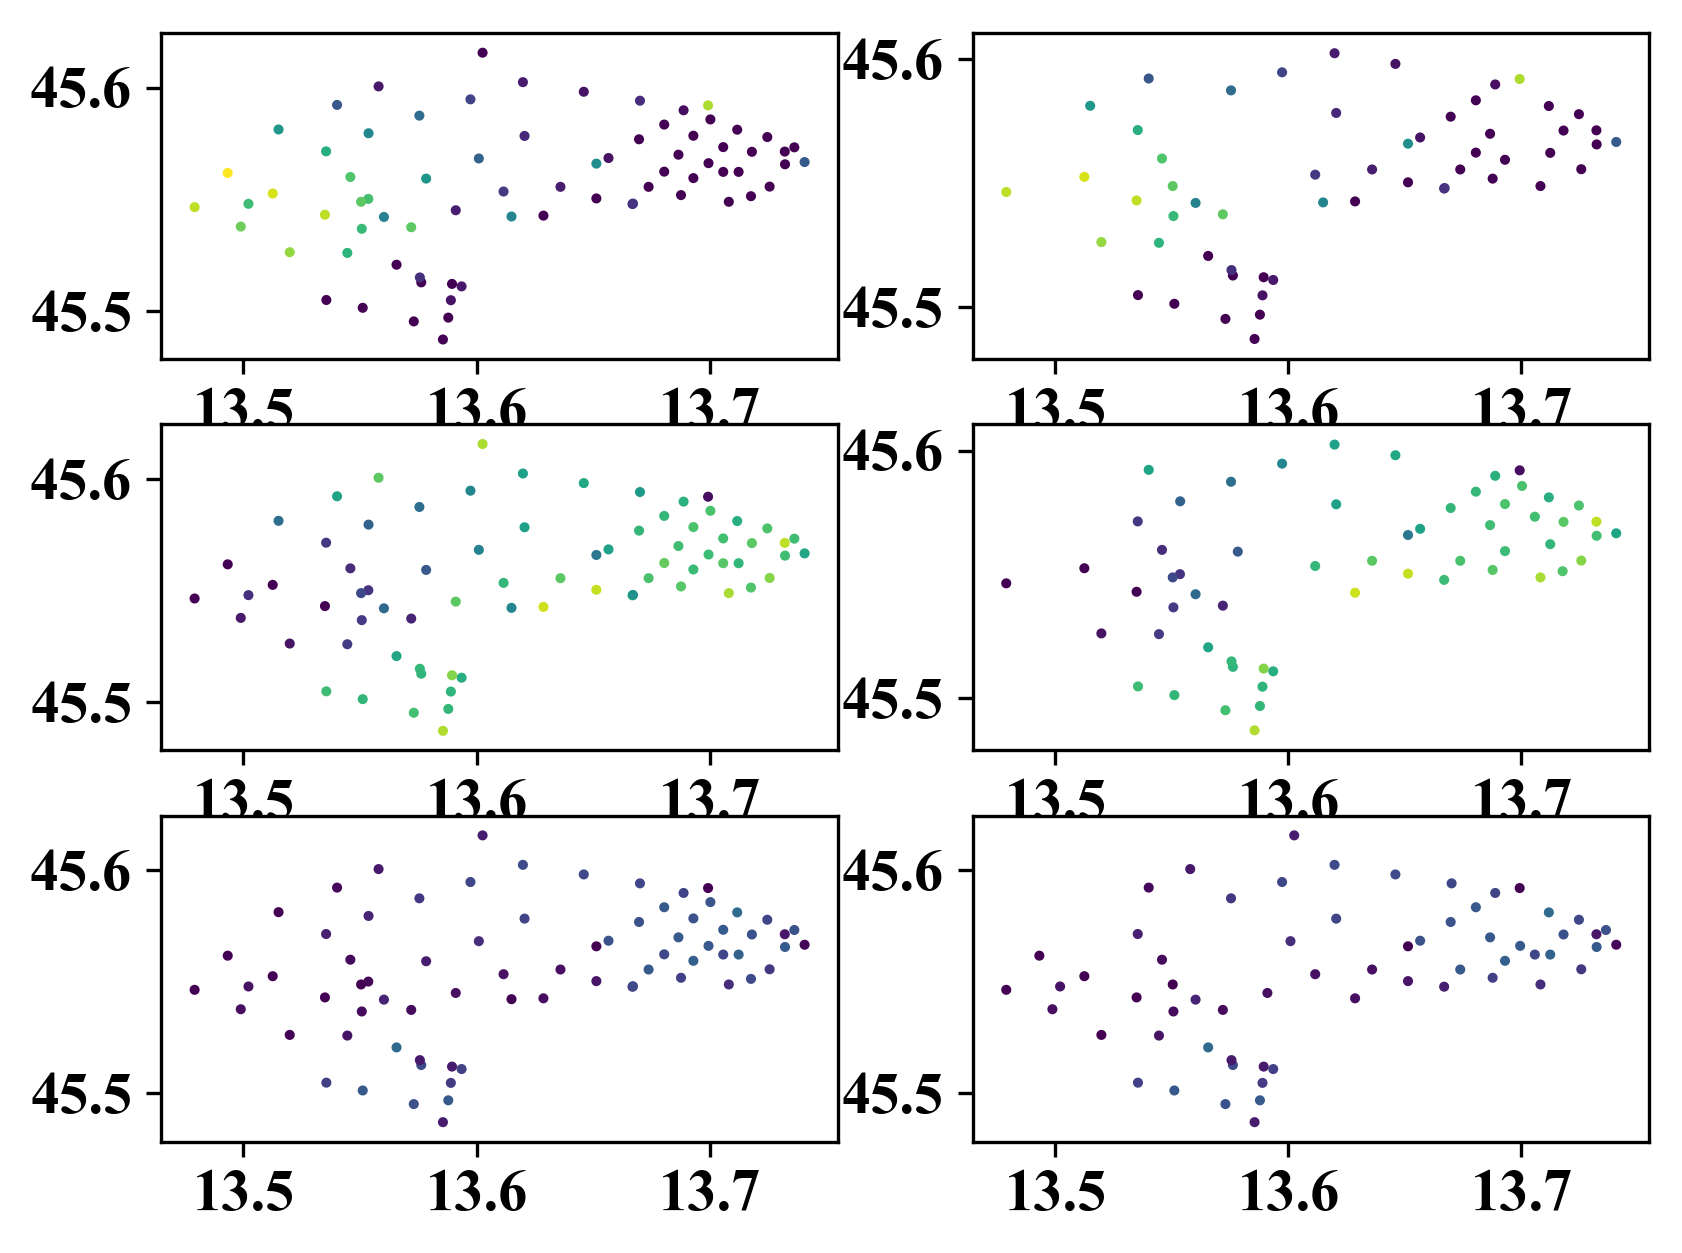

In [36]:
PyPlot.figure()
ax = PyPlot.subplot(321)
PyPlot.scatter(obslon, obslat, c=sand, s=2, vmin=10., vmax=90.)
ax = PyPlot.subplot(322)
PyPlot.scatter(obslon, obslat, c=sand_ref, s=2, vmin=10., vmax=90.)

ax = PyPlot.subplot(323)
PyPlot.scatter(obslon, obslat, c=silt, s=2, vmin=10., vmax=90.)
ax = PyPlot.subplot(324)
PyPlot.scatter(obslon, obslat, c=silt_ref, s=2, vmin=10., vmax=90.)

ax = PyPlot.subplot(325)
PyPlot.scatter(obslon, obslat, c=clay, s=2, vmin=10., vmax=90.)
ax = PyPlot.subplot(326)
PyPlot.scatter(obslon, obslat, c=clay_ref, s=2, vmin=10., vmax=90.)

PyPlot.show()

Check the quantity of data that were removed.

In [37]:
(length(sedimentall) - length(sedimentall_ref)) / length(sedimentall)

0.1981981981981982

We get about 20% of the measurements removed, since we removed 2 values in 10% of the locations.

## Analysis
### Grid, metrics and mask

In [38]:
xxi, yyi, zzi = ndgrid(gridlon, gridlat, range(1.,stop=3.,step=1));
mask = trues(size(xxi));
pm = ones(size(xxi)) / (xxi[2,1,1] - xxi[1,1,1]);
pn = ones(size(xxi)) / (yyi[1,2,1] - yyi[1,1,1]);
pq = ones(size(xxi)) / (zzi[1,1,2] - zzi[1,1,1]);
mmask3 = repeat(mmask, 1, 1, 3);
@info(size(mmask3));

┌ Info: (121, 57, 3)
└ @ Main In[38]:7


### Set the analysis parameters.     
The correlation length: set to zero for the last dimension

In [39]:
epsilon2 = 0.1;
sz = size(mmask3);
lenx = fill(0.03,sz)   
leny = fill(0.03,sz) 
lenz = zeros(sz);      
len = (lenx, leny, lenz);

### 1. All the fields together, no sum constrain

In [40]:
fi1, s1 = DIVAndrun(mmask3,(pm,pn,pq), (xxi, yyi, zzi),
    (obslon2,obslat2,zzz), sedimentall, len, epsilon2);

### 2. All the fields with missing data, no constrain

In [41]:
fi2, s2 = DIVAndrun(mmask3,(pm,pn,pq), (xxi, yyi, zzi),
    (obslon_ref,obslat_ref,zzz_ref), sedimentall_ref, len, epsilon2);

### 3. All the fields with missing data, sum constrain

In [42]:
fi3, s3 = DIVAndrun(mmask3,(pm,pn,pq), (xxi, yyi, zzi),
    (obslon_ref,obslat_ref,zzz_ref), sedimentall_ref, len, epsilon2; epsilon2forfractions=0.1);

### Comparison plot

In [43]:
function make_subplot(gridlon, gridlat, finterp, obslon, obslat, field)
    pcm1 = PyPlot.pcolormesh(gridlon, gridlat, finterp, vmin=0, vmax=100.)
    PyPlot.scatter(obslon, obslat, s=2, c=field, vmin=0., vmax=100.)
    add_mask(bx, by, b)
    ax1.tick_params("both",labelsize=6)
    gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
end

make_subplot (generic function with 1 method)

In [44]:
function make_subplot_total(gridlon, gridlat, finterp, obslon, obslat)
    pcm1 = PyPlot.pcolormesh(gridlon, gridlat, finterp, cmap=PyPlot.cm.RdBu_r, vmin=-0.01, vmax=0.01)
    PyPlot.colorbar(pcm1).ax.tick_params(labelsize=8)
    PyPlot.plot(obslon, obslat, "ko", ms=.5)
    add_mask(bx, by, b)
    ax1.tick_params("both",labelsize=6)
    gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
end

make_subplot_total (generic function with 1 method)

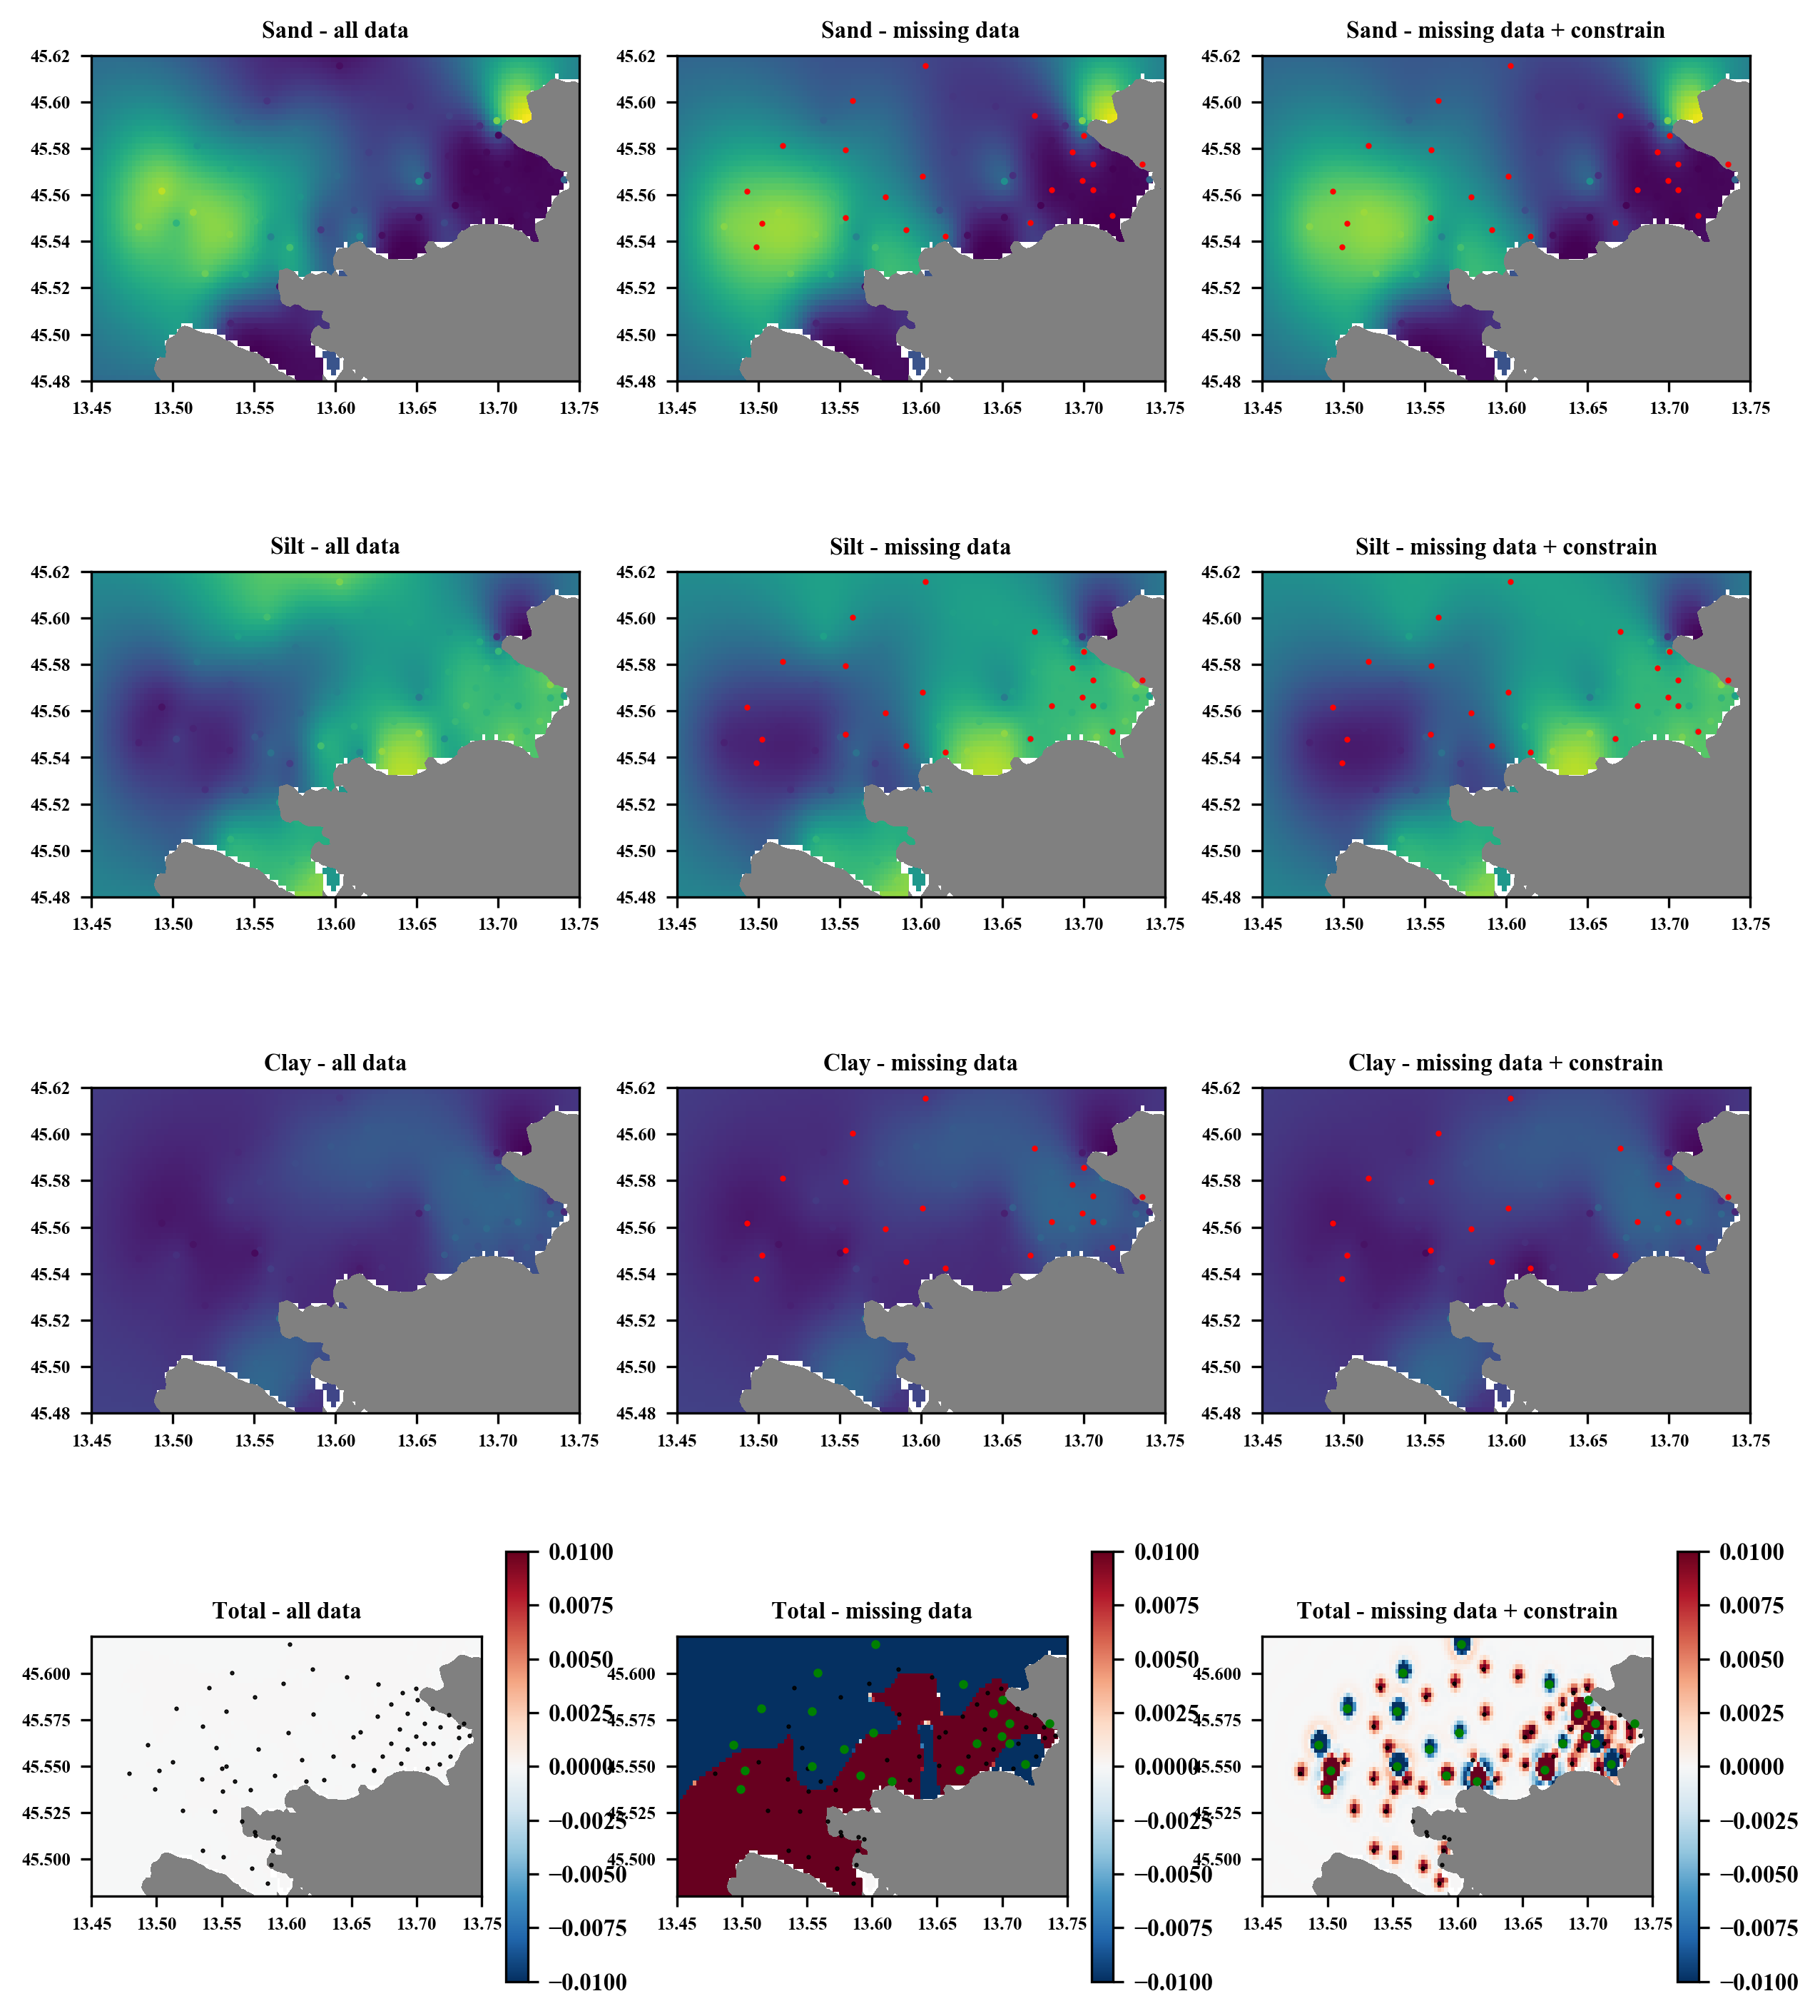

In [45]:
PyPlot.figure(figsize=(10, 12))
ax1 = subplot(431)
title("Sand - all data", fontsize=8)
make_subplot(gridlon, gridlat, mean(sand) .+ permutedims(fi1[:,:,1], [2,1]), obslon, obslat, sand)

ax1 = subplot(432)
title("Sand - missing data", fontsize=8)
PyPlot.plot(obslon[random_pos], obslat[random_pos], "ro", ms=1)
make_subplot(gridlon, gridlat, mean(filter(!isnan, sand_ref)) .+ permutedims(fi2[:,:,1], [2,1]), 
    obslon, obslat, sand_ref)

ax1 = subplot(433)
title("Sand - missing data + constrain", fontsize=8)
PyPlot.plot(obslon[random_pos], obslat[random_pos], "ro", ms=1)

make_subplot(gridlon, gridlat, mean(filter(!isnan, sand_ref)) .+ permutedims(fi3[:,:,1], [2,1]), 
    obslon, obslat, sand_ref)

ax1 = subplot(434)
title("Silt - all data", fontsize=8)
make_subplot(gridlon, gridlat, mean(silt) .+ permutedims(fi1[:,:,2], [2,1]), obslon, obslat, silt)

ax1 = subplot(435)
title("Silt - missing data", fontsize=8)
PyPlot.plot(obslon[random_pos], obslat[random_pos], "ro", ms=1)
make_subplot(gridlon, gridlat, mean(filter(!isnan, silt_ref)) .+ permutedims(fi2[:,:,2], [2,1]), 
    obslon, obslat, silt_ref)

ax1 = subplot(436)
title("Silt - missing data + constrain", fontsize=8)
PyPlot.plot(obslon[random_pos], obslat[random_pos], "ro", ms=1)
make_subplot(gridlon, gridlat, mean(filter(!isnan, silt_ref)) .+ permutedims(fi3[:,:,2], [2,1]), 
    obslon, obslat, silt_ref)

ax1 = subplot(437)
title("Clay - all data", fontsize=8)
make_subplot(gridlon, gridlat, mean(clay) .+ permutedims(fi1[:,:,3], [2,1]), obslon, obslat, clay_corrected)

ax1 = subplot(438)
title("Clay - missing data", fontsize=8)
PyPlot.plot(obslon[random_pos], obslat[random_pos], "ro", ms=1)
make_subplot(gridlon, gridlat, mean(filter(!isnan, clay_ref)) .+ permutedims(fi2[:,:,3], [2,1]), 
    obslon, obslat, clay_ref)

ax1 = subplot(439)
title("Clay - missing data + constrain", fontsize=8)
PyPlot.plot(obslon[random_pos], obslat[random_pos], "ro", ms=1)
make_subplot(gridlon, gridlat, mean(filter(!isnan, clay_ref)) .+ permutedims(fi3[:,:,3], [2,1]), 
    obslon, obslat, clay_ref)

# Totals

ax1 = subplot(4,3,10)
title("Total - all data", fontsize=8)
make_subplot_total(gridlon, gridlat, permutedims(sum(fi1, dims=3)[:,:,1], [2,1]), obslon, obslat)

ax1 = subplot(4,3,11)
title("Total - missing data", fontsize=8)
make_subplot_total(gridlon, gridlat, permutedims(sum(fi2, dims=3)[:,:,1], [2,1]), obslon, obslat)
PyPlot.plot(obslon[random_pos], obslat[random_pos], "go", ms=2)

ax1 = subplot(4,3,12)
title("Total - missing data + constrain", fontsize=8)
make_subplot_total(gridlon, gridlat, permutedims(sum(fi3, dims=3)[:,:,1], [2,1]), obslon, obslat)
PyPlot.plot(obslon[random_pos], obslat[random_pos], "go", ms=2)

PyPlot.savefig(joinpath("./figures/", "sediment_method_comparison02.png"), dpi=300, bbox_inches="tight")

In [46]:
@show rmsd(filter(!isnan, fi2[:,:,1]), filter(!isnan, fi1[:,:,1]));
@show rmsd(filter(!isnan, fi3[:,:,1]), filter(!isnan, fi1[:,:,1]));

@show rmsd(filter(!isnan, fi2[:,:,2]), filter(!isnan, fi1[:,:,2]));
@show rmsd(filter(!isnan, fi3[:,:,2]), filter(!isnan, fi1[:,:,2]));

@show rmsd(filter(!isnan, fi2[:,:,3]), filter(!isnan, fi1[:,:,3]));
@show rmsd(filter(!isnan, fi3[:,:,3]), filter(!isnan, fi1[:,:,3]));

rmsd(filter(!isnan, fi2[:, :, 1]), filter(!isnan, fi1[:, :, 1])) = 5.882241209093762
rmsd(filter(!isnan, fi3[:, :, 1]), filter(!isnan, fi1[:, :, 1])) = 5.802747290705915
rmsd(filter(!isnan, fi2[:, :, 2]), filter(!isnan, fi1[:, :, 2])) = 5.827309523725606
rmsd(filter(!isnan, fi3[:, :, 2]), filter(!isnan, fi1[:, :, 2])) = 5.781705036996306
rmsd(filter(!isnan, fi2[:, :, 3]), filter(!isnan, fi1[:, :, 3])) = 0.7146954585423607
rmsd(filter(!isnan, fi3[:, :, 3]), filter(!isnan, fi1[:, :, 3])) = 0.9534230355222256
